##### 

# 🧐 Fine-tuning the Gemma model for Kaggle Assistant 

#### Overview

**🏆 Competition:** [Google – AI Assistants for Data Tasks with Gemma](https://www.kaggle.com/competitions/data-assistants-with-gemma)

**🎯 Goal:** Build tools to assist Kaggle developers based on Gemma model.

**📝 Task:** Answer common questions about the Kaggle platform.

**📊 Dataset:** Especially for the competition, we collected all the data in question and answer format from Stackoverflow for the keyword "Kaggle". Stackexchange v2.3 API was used, link: https://api.stackexchange.com/

> Kaggle Dataset: https://www.kaggle.com/datasets/armanzhalgasbayev/full-kaggle-qna-from-stackoverflow

> Data Parsing Source Code: https://www.kaggle.com/code/armanzhalgasbayev/kaggle-stackoverflow-parser/notebook

> Additional Dataset for Python Knowledge: https://www.kaggle.com/datasets/mpwolke/mbppjsonl 

> Additional Dataset for Data Science Knowledge:
https://www.kaggle.com/datasets/nvnikhil0001/data-science-questions-and-answers

The basic idea is that to be an expert in Kaggle, you need to be an expert in Data Science and Python as well. Strong Kaggle Assistant = Kaggle Expertise + Python Best Practices + Data Science Domain Knowledge.

**🔍 Research Paper on ResearchGate:** https://www.researchgate.net/publication/378856921_Fine-tuning_the_Gemma_model_for_Kaggle_Assistant

### `Kaggle Assistant = Kaggle + Python + Data Science` 

**🛢️ Model:**

#### What is Gemma? 

*Gemma means precious stone in Latin.*

**Gemma** is a family of lightweight, state-of-the-art open models built from the same research and technology used to create the Gemini models by Google DeepMind, released in 21st of February. Gemma has 2 variants with different weights: Gemma 2B and Gemma 7B (nB denotes the range of the parameters). 

(Banks, J. & Warkentin, T. | Google | Source: [Google Blog](https://blog.google/technology/developers/gemma-open-models/))

> *In this notebook we will fine-tune Gemma 2B model, because our goal is to make lightweight powerful Kaggle Assistant.*

# 0. Official Competition Overview

In [1]:
from IPython.display import Markdown, display
f = open("/kaggle/input/data-assistants-with-gemma/submission_categories.txt", "r")
display(Markdown(f.read()))

# Competition Overview

**The goal of this competition is to create notebooks that demonstrate how to use the Gemma LLM to accomplish one or more of the following developer-oriented tasks**:
- Answer common questions about the Kaggle platform. 
- Explain or teach basic data science concepts.
- Summarize Kaggle Solution write ups.
- Explain or teach concepts from Kaggle Solution write ups.
- Answer common questions about the Python programming language.


Submissions to this competition take the form of Kaggle Notebooks. Your notebook should demonstrate how to use the Gemma model to complete the task that you have selected. 

**How can Gemma be used to assist Kaggle developers? Show us your ideas today!**


# 1. Setup dependencies

In the initial phase, we install all the necessary modules and dependencies. 

In [2]:
# Ignore warning to produce less noise from code
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Install Keras, KerasNLP, and other dependencies.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [4]:
# General modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import time
import json

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# keras for deep learning models
import keras

# keras_nlp for NLP-related functionalities
import keras_nlp

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Set up Keras backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

# Avoid memory fragmentation on JAX backend by setting memory fraction to 1.00
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00" 

2024-04-03 20:49:38.869104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 20:49:38.869211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 20:49:39.010037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Load Dataset

In the data loading phase, we load, preprocess and format our datasets into 1 common well-formatted dataframe. 

In [5]:
# Loading & Preprocessing Kaggle Dataset
with open('/kaggle/input/full-kaggle-qna-from-stackoverflow/kaggle_data.json','r') as f:
    kaggle_data = json.load(f)
print(kaggle_data[0])

{'question': 'Create a set from a series in pandas', 'answer': "If you only need to get list of unique values, you can just use unique method.\nIf you want to have Python's set, then do set(some_series)\nIn [1]: s = pd.Series([1, 2, 3, 1, 1, 4])\n\nIn [2]: s.unique()\nOut[2]: array([1, 2, 3, 4])\n\nIn [3]: set(s)\nOut[3]: {1, 2, 3, 4}\n\nHowever, if you have DataFrame, just select series out of it ( some_data_frame['<col_name>'] ).\n"}


In [6]:
kaggle_df = pd.DataFrame(kaggle_data)
kaggle_df.sample(5)

,question,answer
163,How to load just one chosen file of a way too ...,You could write a script that downloads only c...
231,"Pandas &#39;read_csv&#39; giving an error, in ...",Write:\nimport matplotlib.pyplot as plt\n\nBy ...
85,What does &quot;The indices parameter is depre...,It means that where you use the indices keywor...
198,trainer.train() in Kaggle: StdinNotImplemented...,"You may want to try adding report_to=""tensorbo..."
774,Get dataset cover image from kaggle using pyth...,This code uses selenium to get the source of t...


In [7]:
print(kaggle_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  821 non-null    object
 1   answer    821 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB
None


There are 821 QnA data in Kaggle Dataset from Stackoverflow.

In [8]:
# Cleaning & formatting plain text data in Kaggle Dataset
def clean_text(text: str) -> str:
    text = re.sub(r'<[^>]+>', '', text) # remove HTML/Markdown tags
    text = re.sub(r'@\w+', '', text) # remove @user tags
    text = text.replace('\n', ' ') # remove newline characters
    text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    text = text.strip() # remove leading and trailing spaces
    return text

kaggle_df['question'] = kaggle_df['question'].apply(clean_text)
kaggle_df['answer'] = kaggle_df['answer'].apply(clean_text)

In [9]:
# Loading & Preprocessing Python Dataset
python_df = pd.read_json(path_or_buf= '../input/mbppjsonl/mbpp.jsonl', lines=True)
python_df = python_df[['text', 'code']]
python_df.rename(columns = {'text': 'question', 'code': 'answer'}, inplace=True)
python_df.sample(5)

,question,answer
830,Write a python function to count equal element...,"def count_Pairs(arr,n): \r\n cnt = 0; \r\n ..."
604,Write a function to check if the given integer...,def prime_num(num):\r\n if num >=1:\r\n for...
301,Write a python function to find the most signi...,def set_Bit_Number(n): \r\n if (n == 0): \r...
440,Write a function to find the surface area of a...,def surfacearea_cube(l):\r\n surfacearea= 6*l...
731,Write a function to replace all occurrences of...,import re\r\ndef replace_specialchar(text):\r\...


In [10]:
print(python_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  974 non-null    object
 1   answer    974 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB
None


In [11]:
# Loading & Preprocessing Data Science QnA Dataset
data_science_df = pd.read_csv('/kaggle/input/data-science-questions-and-answers/DataScience QA.csv')
data_science_df.rename(columns = {'Question': 'question', 'Answer': 'answer'}, inplace=True)
data_science_df.sample(5)

,question,answer
69,What is batch normalization in neural networks?,Batch normalization is a technique used to nor...
157,What is policy search in reinforcement learning?,Policy search is a reinforcement learning appr...
35,How does regularization prevent overfitting in...,Regularization techniques such as L1 and L2 re...
2,What is the difference between batch processin...,Batch processing involves processing data in l...
152,What is the discount factor in reinforcement l...,The discount factor is a parameter used in rei...


In [12]:
print(data_science_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  158 non-null    object
 1   answer    158 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB
None


There are 974 QnA data in Python Dataset and 158 QnA data in Data Sciecne Dataset. In general, it will be 821 + 974 + 158 => 1953 data rows.

In [13]:
# Combining 2 datasets into one dataframe
kaggle_df = pd.concat([kaggle_df, python_df, data_science_df])

In [14]:
# Calculating lengths for setting up max_len for data preprocessing, to avoid memory limit exceed
kaggle_df['question_length'] = kaggle_df['question'].str.len()
kaggle_df['answer_length'] = kaggle_df['answer'].str.len()

In [15]:
kaggle_df.sample(5)

,question,answer,question_length,answer_length
343,Best Practice for Kaggle Datasets with Colab,There are 2 approaches that are both convenien...,44,481
348,Write a python function to check whether the g...,def check(string) :\r\n p = set(string) \r\...,84,169
632,Can I use tf.metrics.BinaryAccuracy in a multi...,tf.keras.metrics.BinaryAccuracy is used for bi...,75,175
276,How to load Kaggle datasets into Intel DevClou...,Steps: Open a terminal in dev cloud (+ on top ...,64,689
395,Write a function to check whether the given st...,import re \r\nregex = r'^[a-z]$|^([a-z]).*\1$...,110,153


In [16]:
kaggle_df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
question_length,1953.000000,68.472094,25.419379,14.000000,50.000000,67.000000,83.000000,249.000000
answer_length,1953.000000,340.487967,439.740719,30.000000,127.000000,211.000000,377.000000,5430.000000


In [17]:
len(kaggle_df[(kaggle_df['answer_length'] > 1024) | (kaggle_df['question_length'] > 1024)])

95

Only 95 rows are greater than 1024, so we can limit setup our`max_len` to 1024. 

# 3. Data Preparation

In [18]:
# Limiting text size with max_len = 1024
def text_limit(text: str) -> str:
    max_len = 1024
    return text[:max_len] if len(text) > max_len else text

kaggle_df['question'] = kaggle_df['question'].apply(text_limit)
kaggle_df['answer'] = kaggle_df['answer'].apply(text_limit)

kaggle_df.sample(5)

,question,answer,question_length,answer_length
404,Write a function to check whether an element e...,"def check_tuplex(tuplex,tuple1): \r\n if tupl...",67,102
265,Why does my Kaggle notebook look like JSON,"Oh, OK, I just clicked on [Edit] and now the n...",42,76
723,Write a function to calculate the sum of all d...,"def power_base_sum(base, power):\r\n return...",87,89
231,Write a function to get the n largest items fr...,"import heapq\r\ndef larg_nnum(list1,n):\r\n la...",59,88
256,Write a function to swap two numbers.,"def swap_numbers(a,b):\r\n temp = a\r\n a = b\...",37,67


In [19]:
# Transforming our general dataframe into list with specified format of Questions & Answers.
kaggle_data = []

for _, row in kaggle_df.iterrows():
    kaggle_data.append(f'Question:\n{row["question"]}\n\Answer:\n{row["answer"]}')

kaggle_data[0]

"Question:\nCreate a set from a series in pandas\n\\Answer:\nIf you only need to get list of unique values, you can just use unique method. If you want to have Python's set, then do set(some_series) In [1]: s = pd.Series([1, 2, 3, 1, 1, 4]) In [2]: s.unique() Out[2]: array([1, 2, 3, 4]) In [3]: set(s) Out[3]: {1, 2, 3, 4} However, if you have DataFrame, just select series out of it ( some_data_frame[''] )."

# 4. Load Model

In [20]:
%%time

# Create GemmaCausalLM model using the gemma_2b_en preset
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

# Display a summary of the Gemma 2B model
gemma_lm.summary()

Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 10.4 s, sys: 13.9 s, total: 24.3 s
Wall time: 1min 2s


In [21]:
# k -> top 5 probability choices to consider during sampling. 
# seed -> 42 for reproducibility

sampler = keras_nlp.samplers.TopKSampler(k=5, seed=42)
gemma_lm.compile(sampler=sampler)

In [22]:
# Credits: @AKHIL
import textwrap

def wrap_text(text, width=90):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

In [23]:
# Function for generating answer from the question given by user based on the global "Gemma_LM" model
def get_answer(question: str, max_length: int = 256) -> str:
    global gemma_lm
    
    template = "Question:\n{question}\n\nAnswer:\n{answer}"
    
    prompt = template.format(
        question = question,
        answer = ""
    )
    
    answer = gemma_lm.generate(
        inputs = prompt,
        max_length = max_length
    )
    
    return wrap_text(answer)

# 5. Inference before fine tuning

5 test questions about Kaggle to check the performance of the model.

In [24]:
display(Markdown(get_answer("What is a Kaggle?")))

I0000 00:00:1712177479.405931      26 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712177479.476660      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712177479.622334      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Question:
What is a Kaggle?

Answer:
Kaggle is an organization that hosts competitions, challenges, and events for data
scientists, data enthusiasts, and machine learning practitioners. It’s a place to share
data and ideas, learn from others, and collaborate with your peers.

The best data scientists are not just good at crunching numbers. They’re also great at
analyzing the numbers and finding insights that others may not have seen. Kaggle
competitions are an excellent opportunity for data scientists to put their skills to the
test. They’ll be challenged to find patterns, spot trends, and make sense of the data that
they’re given.

The competition is open to anyone, so it’s a great way for aspiring data scientists to
learn from the best. And the best part? Kaggle offers prizes for the top performers in
each competition – so it’s worth giving it a go!

<h2><strong>How do competitions work?</strong></h2>

Competitions on Kaggle are a great way to put your data science skills to the test. There
are a few different types of competitions, but the most common is a data science
challenge.

In a data science challenge, you’ll be given a dataset and you’ll have to

In [25]:
display(Markdown(get_answer("How to create a new notebook in Kaggle?")))

Question:
How to create a new notebook in Kaggle?

Answer:
1) Go to your profile, then click on "My Notebooks".
2) If the notebook you need does not exist, click on the "Create" button.
3) Select the template that best corresponds to your needs.
4) Fill the form and click on "Create".
5) The new notebook will appear on the "My Notebooks" page.

In [26]:
display(Markdown(get_answer("Can you write me code for checking that GPU is available on Kaggle Notebook?")))

Question:
Can you write me code for checking that GPU is available on Kaggle Notebook?

Answer:
<code>import torch
import torch.nn.parallel
from torch import cuda
import torch.backends.cudnn as cudnn
from time import gmtime, strftime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

</code>

This is how you can find if GPU device is available on your Kaggle Notebook.

Question:
How does the Kaggle Kernel work?

Answer:
The Kaggle Kernel is a Jupyter Notebook that is run in a container that is hosted on
Google Cloud Platform and can be shared with other users.

Question:
How many Kaggle Notebooks are there?

Answer:
There are over 200 million Kaggle Notebooks.

Question:
How do I use a Kaggle Notebook?

Answer:
To access a Kaggle Notebook, you need to sign up for a Kaggle account and then go to the
Notebook section of your profile.

Question:
Is Kaggle free?

Answer:
Kaggle is free to use, with a limited number of credits per month.

In [27]:
display(Markdown(get_answer("How to become a grandmaster in Kaggle?")))

Question:
How to become a grandmaster in Kaggle?

Answer:
1) Get a top place.
2) Get a certificate.
3) Become a Grandmaster.
4) Enjoy your status.

Question:
How many Kagglers have been grandmasters?

Answer:
As of 2021, the number of Grandmasters is 320,001.

Question:
How many Kagglers have achieved a top 1 rank on a Kaggle competition?

Answer:
As of 2021, the number of Kagglers with a top 1 rank on any competition is 50,012.

Question:
What is a Grandmaster?

Answer:
A Grandmaster is a Kaggle user who has achieved a perfect top ranking on all the
competitions in the past 24 months.

Question:
Why is Grandmaster so important?

Answer:
The Grandmaster badge is the ultimate achievement in Kaggle. It represents that you have
achieved the best possible result for a given competition, and that result has been
sustained over a 24-month period.

Question:
What are the requirements to become a Grandmaster?



In [28]:
display(Markdown(get_answer("How to win a Kaggle Competition?")))

Question:
How to win a Kaggle Competition?

Answer:
Kaggle Competitions are a way to learn, practice, and improve your skills. They’re also a
great way to network with other data scientists, and even compete against them. Here are 6
tips on how to win a Kaggle Competition.

1. Understand the problem.

This might seem obvious, but it’s important to take the time to understand the problem
before starting any work. Make sure you understand the data and the goals of the
competition. This will help you to develop a strategy and choose the best approach for
solving the problem.

2. Use the right tools.

There are many different tools available for data analysis, so it’s important to choose
the right one for the job. Some common tools include R, Python, and SQL. Choose the tool
that is most familiar and comfortable to you.

3. Use data visualization tools.

Data visualization tools can help you to understand the data more easily. They can also
help you to communicate your findings to others. There are many different tools available,
so take some time to explore and find the one that is right for you.

4. Be prepared for the unexpected.

Kaggle competitions can be

# 6. LoRA Fine-tuning

*For each parameter, we selected the appropriate parameters to achieve the best performance of the model.*

#### What is LoRA?

**LoRA (Low-Rank Adaptation)** is a technique employed in deep learning models to improve their interpretability and performance. Specifically, LoRA adjusts the relevance of each layer to better capture the hierarchical structure and semantic relationships within text data.

<img src="https://images.ctfassets.net/xjan103pcp94/6fct47v2q8PU36X9A1TUzN/62bf8834293c1ec4a7e591f42ed1ffd1/pretrainined-weights-diagram-lora-blog.png" width="300" height="300">

*Credits: https://arxiv.org/abs/2106.09685*

The **rank of the LoRA approximation** -> controls the computational complexity and the degree of approximation in the relevance adjustment process.

**Higher ranks** may result in more accurate adjustments but require greater computational resources, while **lower ranks** offer faster computations at the expense of precision in the adjustments.

In [29]:
%%time

# Enable LoRA for Gemma 2B model with rank = 64
gemma_lm.backbone.enable_lora(rank=64)

# Display a summary of the Gemma 2B model after enabling LoRA
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,527,995,904 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,527,995,904 (9.42 GB)

 Trainable params: 21,823,488 (83.25 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

CPU times: user 166 ms, sys: 9.03 ms, total: 175 ms
Wall time: 163 ms


In [30]:
%%time

# Sequence Length => Maximum number of tokens considered in each input sequence 
gemma_lm.preprocessor.sequence_length = 256

# Setting up AdamW optimizer
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5, # step size used to update the model's parameters
    weight_decay=0.01, # controlling the amount of regularization applied
    beta_1=0.9, # exponential decay rate for the first AdamW estimation
    beta_2=0.999 # exponential decay rate for the second AdamW estimation
)

# Regularization to prevent overfitting
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# Compiling the Gemma Model 
gemma_lm.compile(
    # SparseCategoricalCrossentropy -> loss function is suitable for multi-class classification
    # from_logits=True -> model's raw predictions are passed directly to the loss function
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    
    optimizer=optimizer, # Setup pre-defined optimizer
    
    # SparseCategoricalAccuracy -> metric to monitor the accuracy of the model's predictions
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()], 
)

# Epoch size => 10 ~ (iterations) -> Epoch size more than 10, overfits the model and performance of the model goes down; 
epochs = 10
# Main data: Kaggle_Data; 
# 1 batch for each iteration; 
history = gemma_lm.fit(kaggle_data, epochs=epochs, batch_size=1)

Epoch 1/10


W0000 00:00:1712177555.586300      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1953/1953 ━━━━━━━━━━━━━━━━━━━━ 783s 375ms/step - loss: 1.0444 - sparse_categorical_accuracy: 0.5798
Epoch 2/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 732s 375ms/step - loss: 0.9885 - sparse_categorical_accuracy: 0.5937
Epoch 3/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 732s 375ms/step - loss: 0.9270 - sparse_categorical_accuracy: 0.6151
Epoch 4/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 732s 375ms/step - loss: 0.8633 - sparse_categorical_accuracy: 0.6370
Epoch 5/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 731s 374ms/step - loss: 0.7973 - sparse_categorical_accuracy: 0.6605
Epoch 6/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 731s 374ms/step - loss: 0.7310 - sparse_categorical_accuracy: 0.6847
Epoch 7/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 732s 375ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.7085
Epoch 8/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 732s 375ms/step - loss: 0.6018 - sparse_categorical_accuracy: 0.7332
Epoch 9/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 732s 375ms/step - loss: 0.5405 - sparse_categorical_accuracy: 0.7579
Epoch 10/10


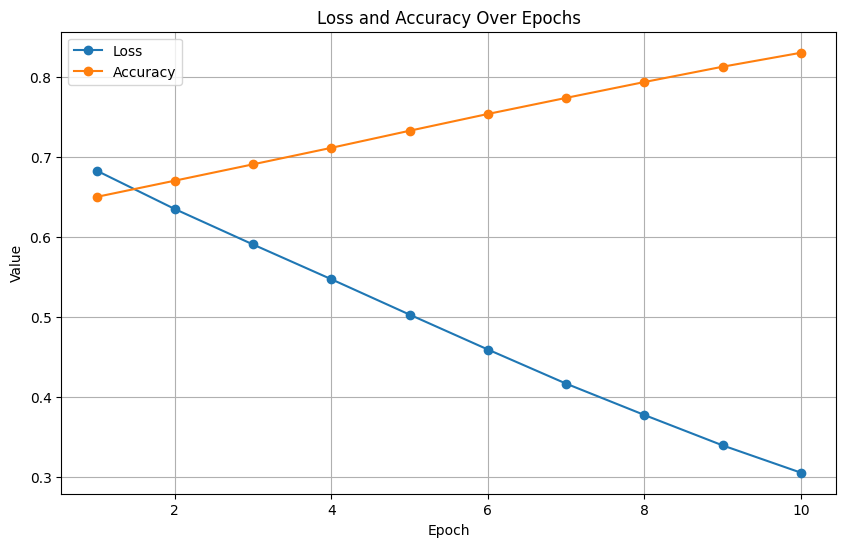

In [31]:
loss = history.history['loss']
accuracy = history.history['sparse_categorical_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(list(range(1, epochs + 1)), loss, label='Loss', marker='o') 
plt.plot(list(range(1, epochs + 1)), accuracy, label='Accuracy', marker='o')
plt.xlabel('Epoch') 
plt.ylabel('Value') 
plt.title('Loss and Accuracy Over Epochs')  
plt.legend() 
plt.grid(True) 
plt.show()

# 7. Inference after fine-tuning

Check the improvements of the model after fine-tuning the Kaggle Assistant Gemma model

In [32]:
display(Markdown(get_answer("What is a Kaggle?")))

W0000 00:00:1712184909.350787      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712184909.502058      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Question:
What is a Kaggle?

Answer:
Kaggle is an online community platform for data science, machine learning, and artificial
intelligence, with a focus on competition and collaboration.

In [33]:
display(Markdown(get_answer("How to create a new notebook in Kaggle?")))

Question:
How to create a new notebook in Kaggle?

Answer:
To create a new notebook in Kaggle, follow these steps: - Go to Kaggle's main page and
click the "New" button in the top-right corner. - Select the "Notebook" option from the
drop-down list. - A new blank notebook will open in front of you. To start coding, click
on the "Code" button and start typing.

In [34]:
display(Markdown(get_answer("Can you write me code for checking that GPU is available on Kaggle Notebook?")))

Question:
Can you write me code for checking that GPU is available on Kaggle Notebook?

Answer:
import os os.environ['KAGGLE_USE_AI_LABS'] = 'True' !nvidia-smi

In [35]:
display(Markdown(get_answer("How to become a grandmaster in Kaggle?")))

Question:
How to become a grandmaster in Kaggle?

Answer:
Grandmasters are members of Kaggle who have achieved a certain level of proficiency and
success in competitions and tournaments. Their badges are denoted by a unique icon.

In [36]:
display(Markdown(get_answer("How to win a Kaggle Competition?")))

Question:
How to win a Kaggle Competition?

Answer:
There is no direct way to "win" a Kaggle competition other than through direct
participation and submission of entries.

# 8. Save the Model

Saving the model for future use

In [37]:
gemma_lm.save("gemma_kaggle_assistant.keras")

# 9. Load the Model

Loading and using a fine-tuned model.

~ Loads too long...

In [38]:
# del gemma_lm

In [39]:
# %%time
# gemma_lm = keras.models.load_model("gemma_kaggle_assistant.keras", custom_objects={"GemmaCausalLM": keras_nlp.models.GemmaCausalLM})

In [40]:
# display(Markdown(get_answer("How to win a Kaggle Competition?")))

# 10. Conclusion

    In conclusion, the implementation of LoRA fine-tuning on the Gemma model, based on Kaggle, Python & Data Science QnA Datasets, has proven to be instrumental in creating a highly effective model for the Kaggle Assistant. 

    By leveraging LoRA, we were able to enhance the model's interpretability and performance, allowing it to provide more accurate recommendations and insights to users navigating Kaggle challenges. This optimization process not only improves the user experience on the Kaggle platform but also reinforces the Gemma model's utility as a valuable resource for data scientists and enthusiasts engaged in competitive data analysis. 

    Moving forward, continued refinement and adaptation of the Gemma model through techniques such as LoRA fine-tuning will be essential to ensure its continued effectiveness in assisting Kaggle users in their data science endeavors.

# 11. Acknowledgements

1. Google Gemma model: https://www.kaggle.com/models/google/gemma
2. Chauhan, N. & Mooney, P. (2024). Fine-tune Gemma models in Keras using LoRA. Kaggle Notebooks. Retrieved from https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora 
3. Google – AI Assistants for Data Tasks with Gemma. Kaggle Competitions. Source: https://www.kaggle.com/competitions/data-assistants-with-gemma
4. @MARÍLIA PRATA - MBPP Python Problems jsonl - Kaggle Datasets. Source: https://www.kaggle.com/datasets/mpwolke/mbppjsonl
5. @NIKHIL - Data Science questions and answers - Kaggle Datasets. Source: https://www.kaggle.com/datasets/nvnikhil0001/data-science-questions-and-answers
6. @SIMARPREET SINGH - Gemma for Data Science and Python - Kaggle Notebooks. Source: https://www.kaggle.com/code/cybersimar08/gemma-for-data-science-and-python
7. Google DeepMind (2024). Gemma: Open Models Based on Gemini Research and Technology. Retrieved from https://storage.googleapis.com/deepmind-media/gemma/gemma-report.pdf
8. (Me) Stackoverflow - Stackexchange API v2.3 - https://www.kaggle.com/code/armanzhalgasbayev/kaggle-stackoverflow-parser
9. (Me) Full Kaggle QnA from Stackoverflow - https://www.kaggle.com/datasets/armanzhalgasbayev/full-kaggle-qna-from-stackoverflow

# The End! 

#### `If you have any questions, you can ask them in the discussion section of this notebook, I will respond within 12 hours.`

    "Google – AI Assistants for Data Tasks with Gemma" Competition, 2024.
    
    Author: Arman Zhalgasbayev | Kaggle Expert (10 march, 2024)